# Исследование оттока клиентов в сети фитнес-центров.
____

### В данном исследовании изучаются причины оттока клиентов и прогнозируется вероятность оттока клиента в следующем месяце.

### Исследование проводится на основе данных, собранных в фитнес-центрах сети.
____

### Исследование разделено на несколько частей.

#### [Часть 1. Подготовка к исследованию и изучение общей информации:](#1)

- [1. Импорт библиотек.](#1.1)
- [2. Получение и изучение общей информации о данных.](#1.2)
- [3. Функции для построения графиков.](#1.3)
- [4. Переводчик.](#1.4)

#### [Часть 2. Исследовательский анализ данных:](#2)

- [1. Изучение средних значений.](#2.1)
- [2. Изучение распределений признаков.](#2.2)
- [3. Изучение корреляций признаков и целевой переменной.](#2.3)

#### [Часть 3. Модель прогнозирования оттока клиентов:](#3)

#### [Часть 4. Кластеризация клиентов:](#4)

#### [Часть 5. Вывод](#5)

## Вывод
1. На вероятность оттока клиента заметно влиют время с момента первого обращения в фитнес-центр, количество месяцев до конца действия абонемента и его длительность, близость локации и возраст.
2. Есть сильная зависимость между длительностью контракта и временем до его окончания и между средним количеством посещений в предыдущий месяц и средним количеством посещений за все время действия абонементов.

## Вывод
При предсказании оттока клиентов больше всего стоит опираться на среднюю посещаемость за предыдущий месяц и на среднюю посещаемость за все время.

## Вывод:
1. Клиентов можно разделить на 5 групп:
    1. Первая группа выделяется отсутствием контактного телефона.
    1. Во второй группе почти нет участников акций, они относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
    1. В третьей группе относительно возрастные клиенты, часто посещающие центр.
    1. В четвертой группе сотрудники компаний-партнеров, относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
    1. Пятая группа выделяется большой длительностью абонементов, относительно возрастные, довольно часто сотрудники компании-партнера.
2. Меньше всего отток у второй группы. Приемлимый отток у 4 и 1 групп. У третьей и пятой групп отток очень высокий.

## Часть 1. Подготовка к исследованию и изучение общей информации. <a id='1'></a>

### 1. Импорт библиотек <a id='1.1'></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

### 2. Получение и изучение общей информации о данных <a id='1.2'></a>

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.info()
display(gym_churn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Надо перевести названия всех столбцов в нижний регистр, а столбец `Month_to_end_contract` сделать целочисленным.

In [3]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')
display(gym_churn.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


Проверим таблицу на наличие дубликатов.

In [4]:
gym_churn.duplicated().sum()

0

### 3. Функции для построения графиков. <a id='1.3'></a>

Гистограмма.

In [5]:
def do_hist(x, bins=20, title='', xlabel='', ylabel='', label=''):
    sns.distplot(x, bins=bins, label=label, hist=True, kde=False, rug=False)
    plt.title(title, size='xx-large')
    plt.xlabel(xlabel, size='x-large')
    plt.ylabel(ylabel, size='x-large')

Countplot.

In [6]:
def do_countplot(y, title, xlabel, ylabel, hue=None):
    sns.countplot(y, hue=hue)
    plt.title(title, size='xx-large')
    plt.xlabel(xlabel, size='x-large')
    plt.ylabel(ylabel, size='x-large')

### 3. Переводчик. <a id='1.3'></a>

In [7]:
translator = {
    'gender': 'пол',
    'near_location' : 'близкая локация',
    'partner' : 'сотрудник компании-партнера',
    'promo_friends' : 'использовал промо-код от знакомого при оплате первого абонемента',
    'phone' : 'наличие контактного телефона',
    'contract_period' : 'Длительность абонемента',
    'group_visits' : 'факт посещения групповых занятий',
    'age' : 'возраст',
    'avg_additional_charges_total' : 'суммарная выручка от других услуг фитнес-центра',
    'month_to_end_contract' : 'количество месяцев до конца контракта',
    'lifetime' : 'время с момента первого обращения в фитнес-центр (в месяцах)',
    'avg_class_frequency_total' : 'средняя частота посещений в неделю за все время',
    'avg_class_frequency_current_month' : 'средняя частота посещений в неделю за предыдущий месяц',
    'churn' : 'факт оттока в текущем месяце',
}

## Часть 2. Исследовательский анализ данных. <a id='2'></a>

### 1. Изучение средних значений. <a id='2.1'></a>

Создадим таблицу со всеми клиентами, которые ушли в отток и таблицу со всеми клиентами, которые не ушли.

In [8]:
churn = gym_churn[gym_churn['churn']==1]
display(churn.head())

not_churn = gym_churn[gym_churn['churn']==0]
display(not_churn.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.786641,1,0,1.213502,1.049387,1
11,1,1,1,0,1,1,0,27,266.783824,1,2,2.348535,1.584316,1
13,1,1,0,0,1,1,1,27,152.748668,1,1,0.000000,0.000000,1
21,0,0,0,0,1,1,0,30,153.198594,1,3,0.636382,0.000000,1
23,1,1,0,0,1,1,1,32,276.079882,1,1,1.420637,1.043101,1


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


Для каждого признака для каждой таблицы (со всеми данными, с теми, кто ушел в отток и с теми кто не ушел) выведем среднее значение и стандартное отклонение. 

In [9]:
datasets = [[gym_churn, 'Общая таблица'], [not_churn, 'Не ушедшие в отток'], [churn, 'Ушедшие в отток']]
features = gym_churn.drop(columns='churn', axis=0)
for column in features:
    print(column)
    print()
    for i in datasets:
        print(i[1])
        print('Среднее значение: {:.2f}; стандартное отклонение: {:.2f}.'.format(i[0][column].mean(), i[0][column].std()))
        
    print()
    print()
    print()        

gender

Общая таблица
Среднее значение: 0.51; стандартное отклонение: 0.50.
Не ушедшие в отток
Среднее значение: 0.51; стандартное отклонение: 0.50.
Ушедшие в отток
Среднее значение: 0.51; стандартное отклонение: 0.50.



near_location

Общая таблица
Среднее значение: 0.85; стандартное отклонение: 0.36.
Не ушедшие в отток
Среднее значение: 0.87; стандартное отклонение: 0.33.
Ушедшие в отток
Среднее значение: 0.77; стандартное отклонение: 0.42.



partner

Общая таблица
Среднее значение: 0.49; стандартное отклонение: 0.50.
Не ушедшие в отток
Среднее значение: 0.53; стандартное отклонение: 0.50.
Ушедшие в отток
Среднее значение: 0.36; стандартное отклонение: 0.48.



promo_friends

Общая таблица
Среднее значение: 0.31; стандартное отклонение: 0.46.
Не ушедшие в отток
Среднее значение: 0.35; стандартное отклонение: 0.48.
Ушедшие в отток
Среднее значение: 0.18; стандартное отклонение: 0.39.



phone

Общая таблица
Среднее значение: 0.90; стандартное отклонение: 0.30.
Не ушедшие в отток
Сре

Судя по этим данным на отток совсем не влияет пол и наличие телефона, зато сильно влияют время с момента первого обращения в фитнес-центр, количество месяцев до конца действия абонемента и его длительность.

### 2. Изучение распределения признаков. <a id='2.2'></a>

Для таблиц с данными клиентов, ушедших в отток и с данными клиентов, не ушедших в отток для каждого признака построим гистограмму.

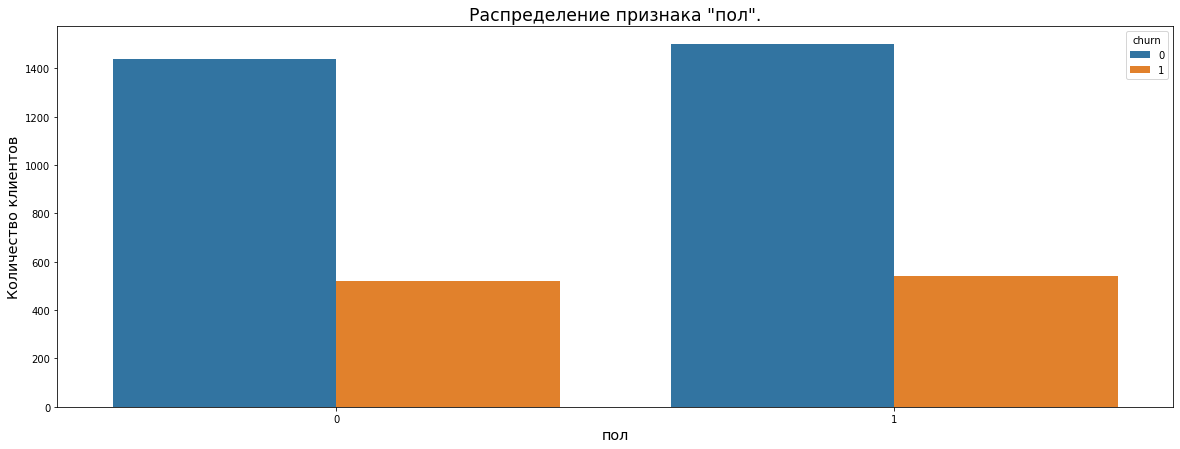

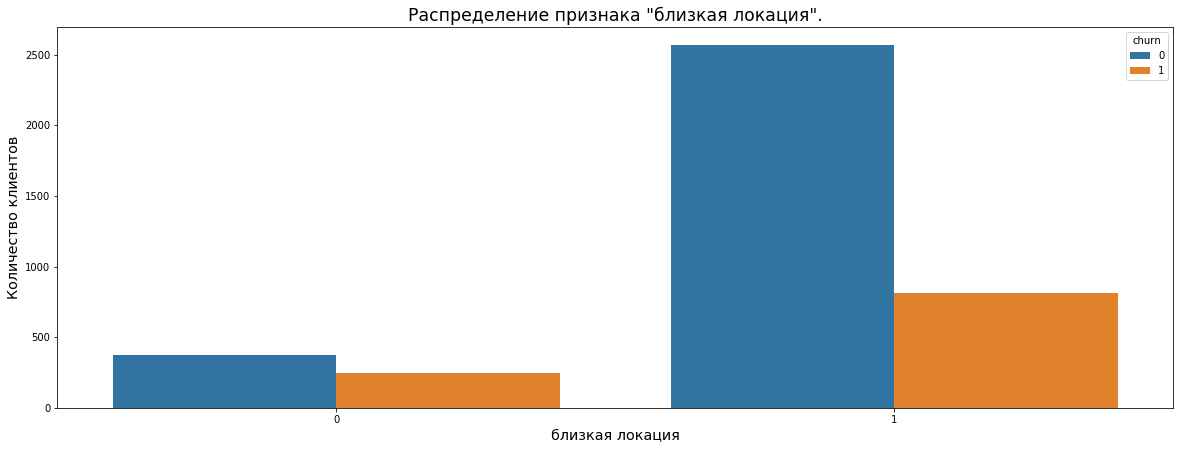

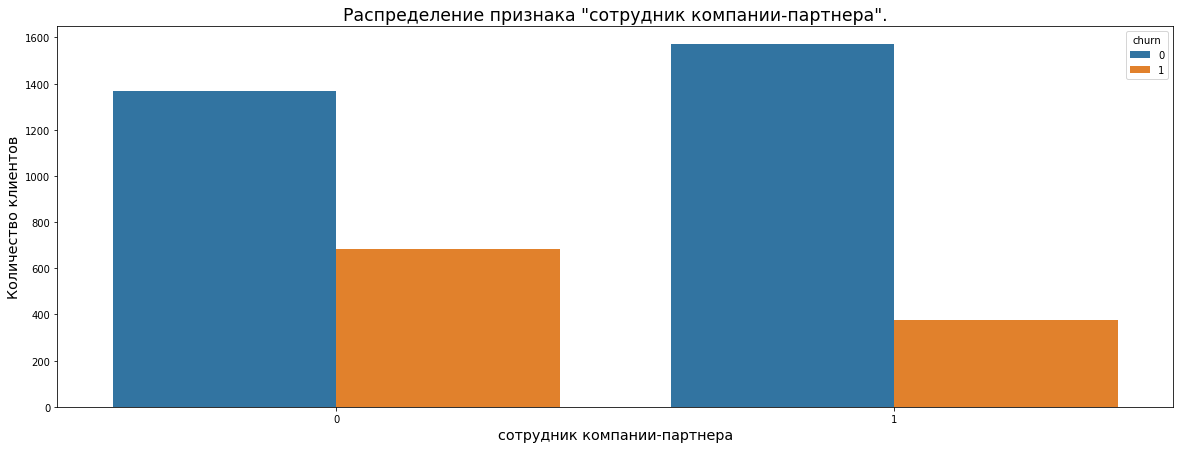

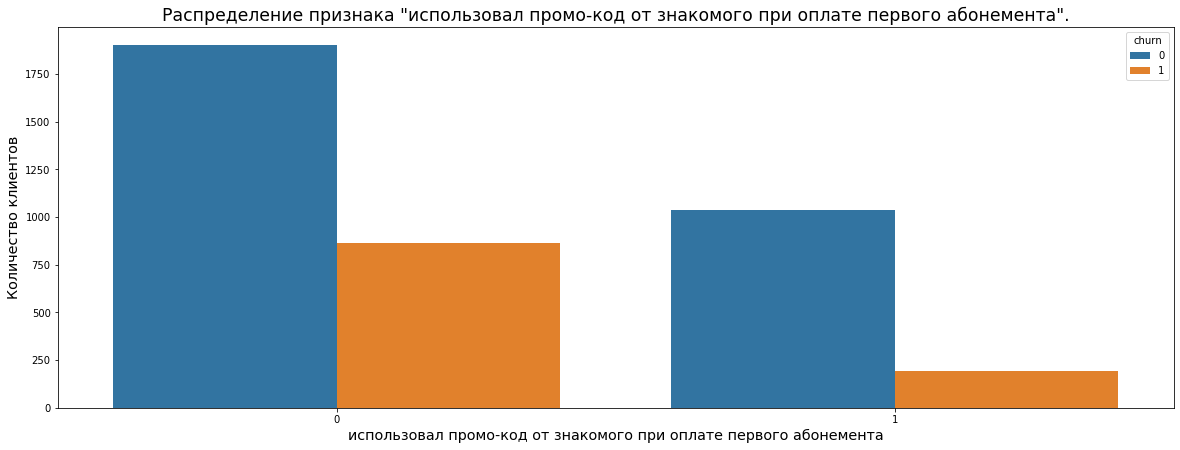

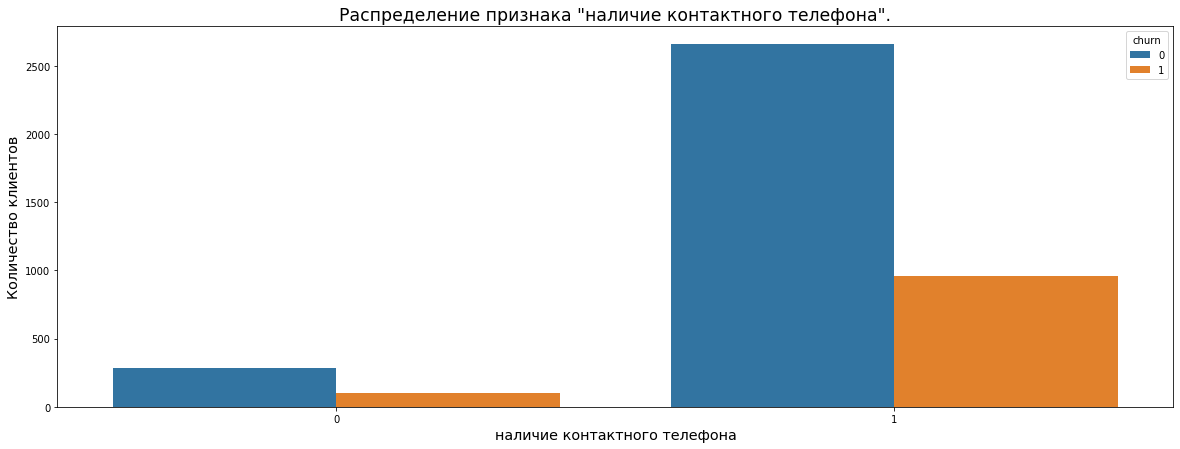

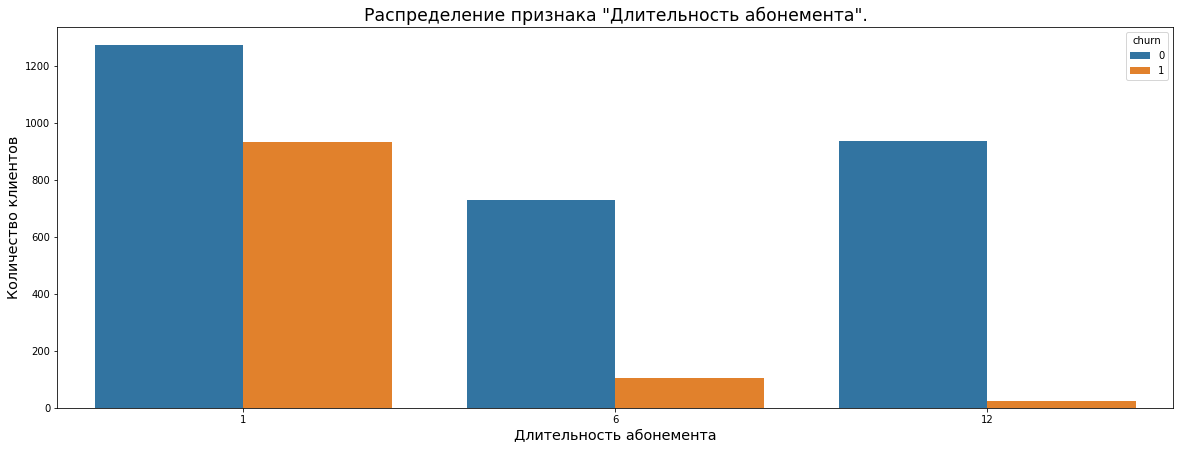

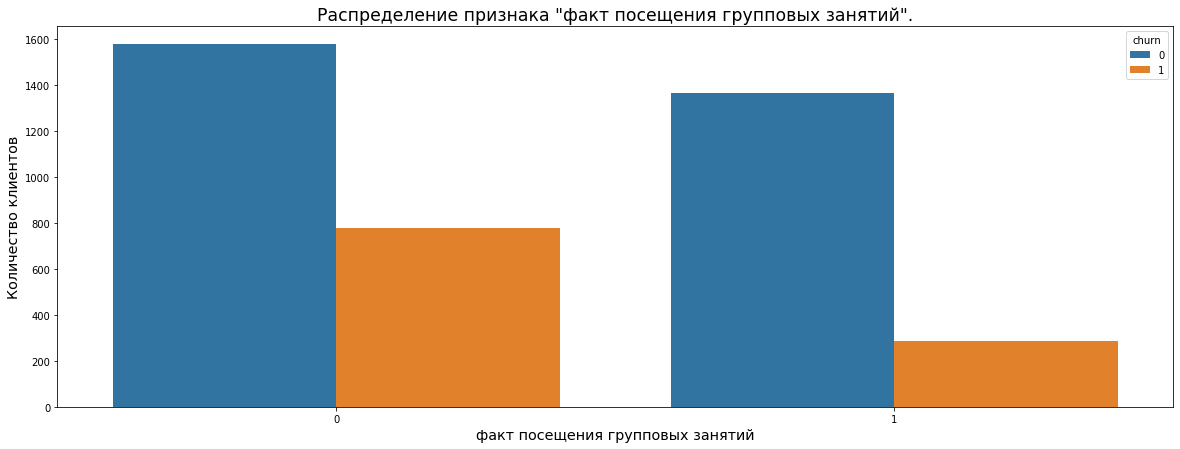

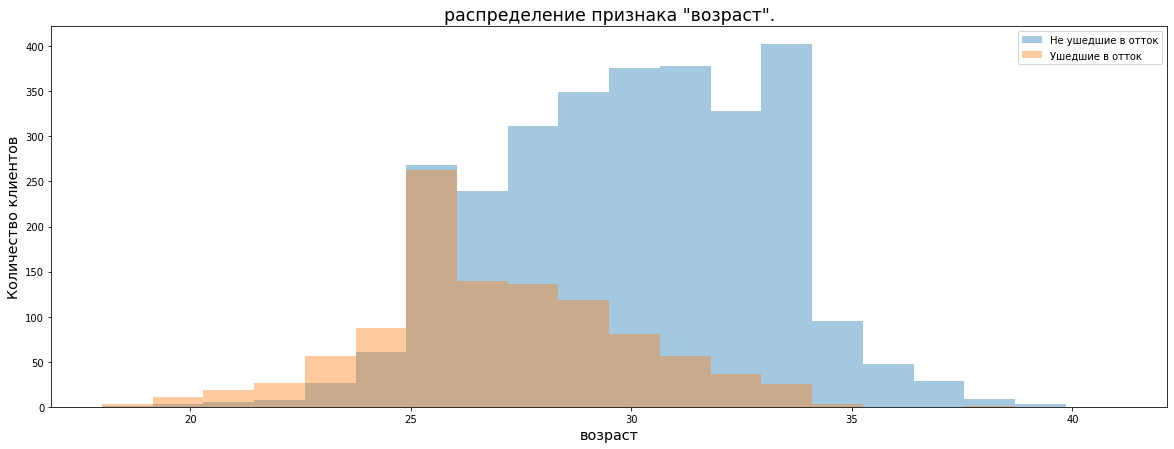

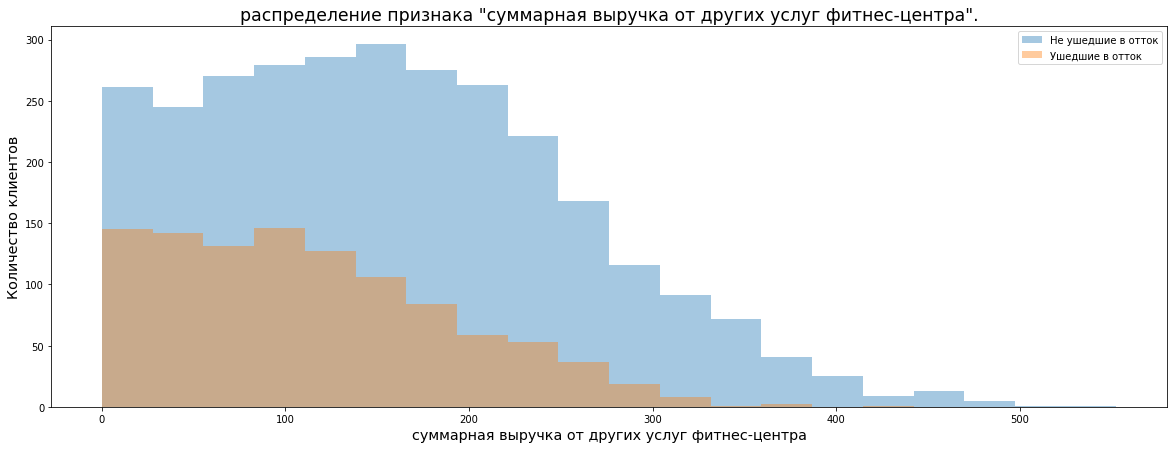

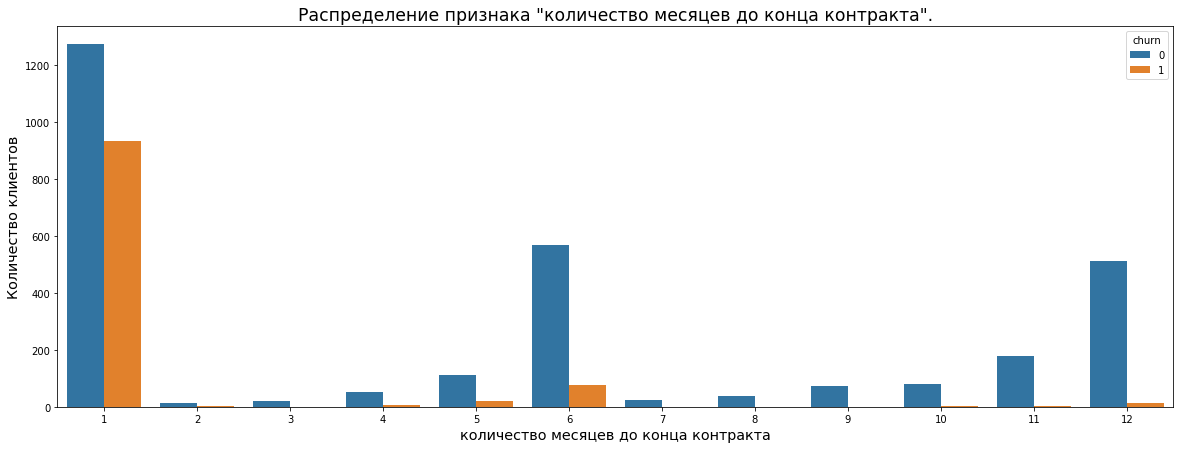

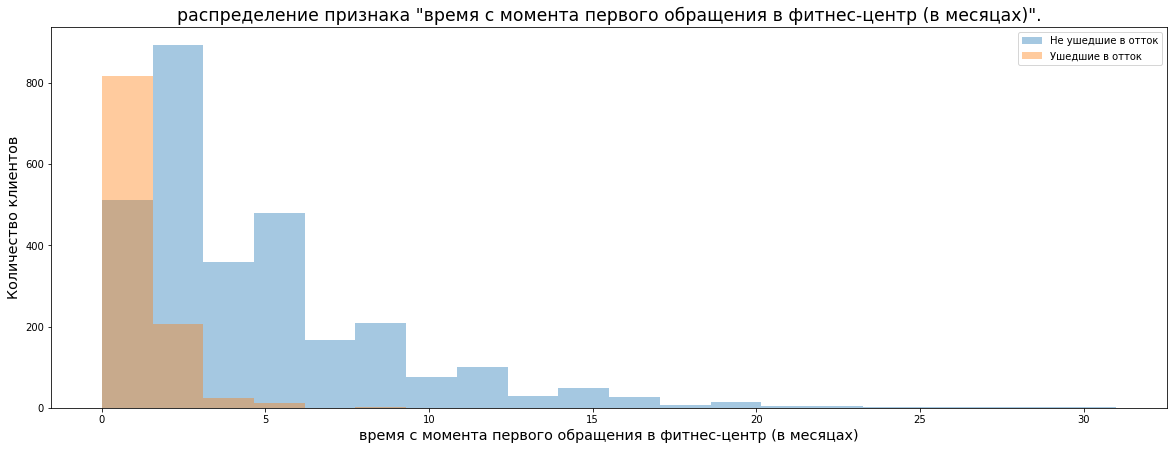

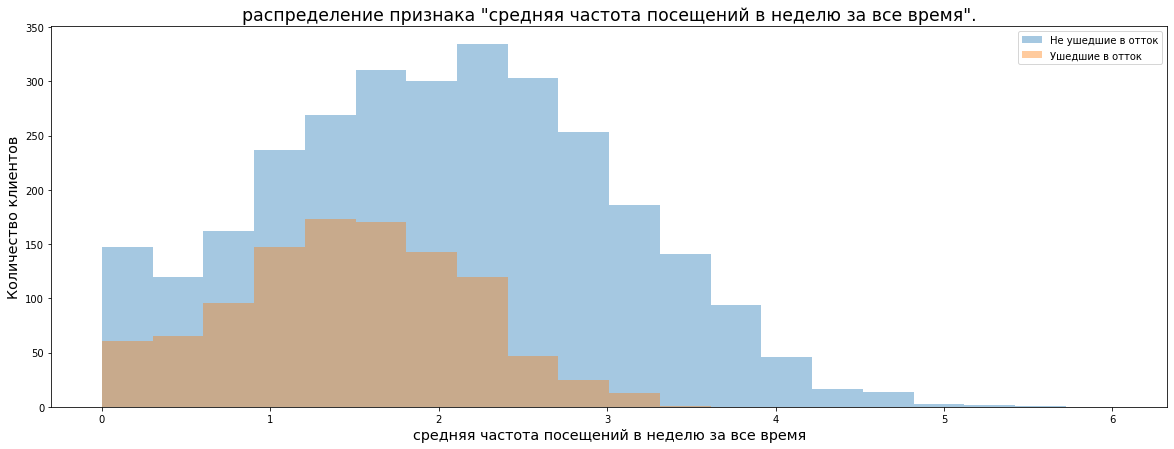

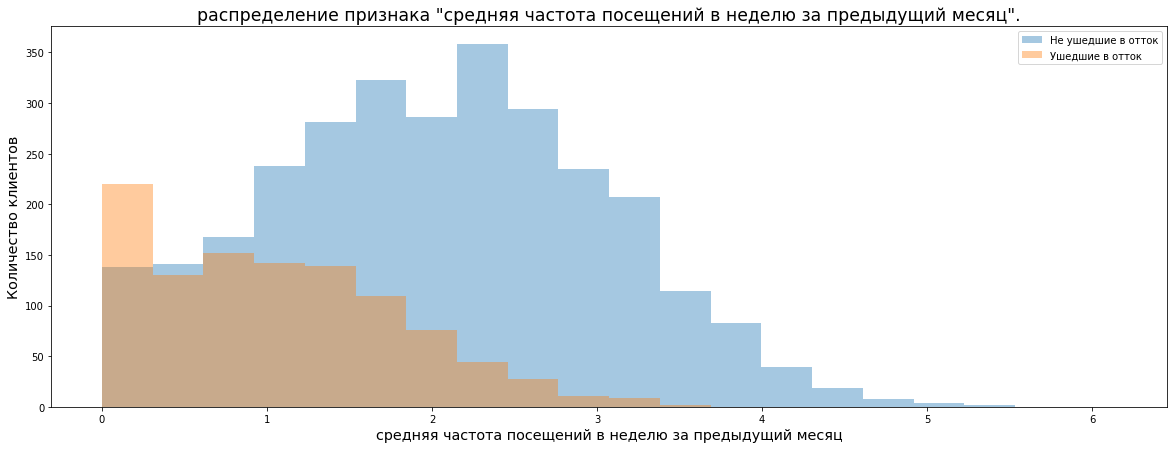

In [10]:
plt.rcParams['figure.figsize']=(20, 7)
for column in features:
    if column in ['age', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total', 'lifetime']:
        x_min = min(datasets[1][0][column].min(), datasets[2][0][column].min())
        x_max = max(datasets[1][0][column].max(), datasets[2][0][column].max())
        step = (x_max - x_min) / 20
        x = x_min
        bins = []
        for i in range(0, 21):
            bins.append(x)
            x += step
        for i in datasets[1:3]:
            do_hist(x=i[0][column], title='распределение признака "'+translator[column]+'".', label=i[1], bins=bins, xlabel=translator[column], ylabel='Количество клиентов')
        plt.legend()
        plt.show()
    else:
        do_countplot(y=gym_churn[column], title='Распределение признака "'+translator[column]+'".', 
                     xlabel=translator[column], ylabel='Количество клиентов', hue=gym_churn['churn'])
        plt.show()

1. Выбросов в данных нет.
1. Заметно влияние длительности абонемента, близости локации, возраста и количества месяцев до конца контракта на вероятность оттока клиента.

### 2. Изучение корреляции признаков и целевой переменной. <a id='2.2'></a>

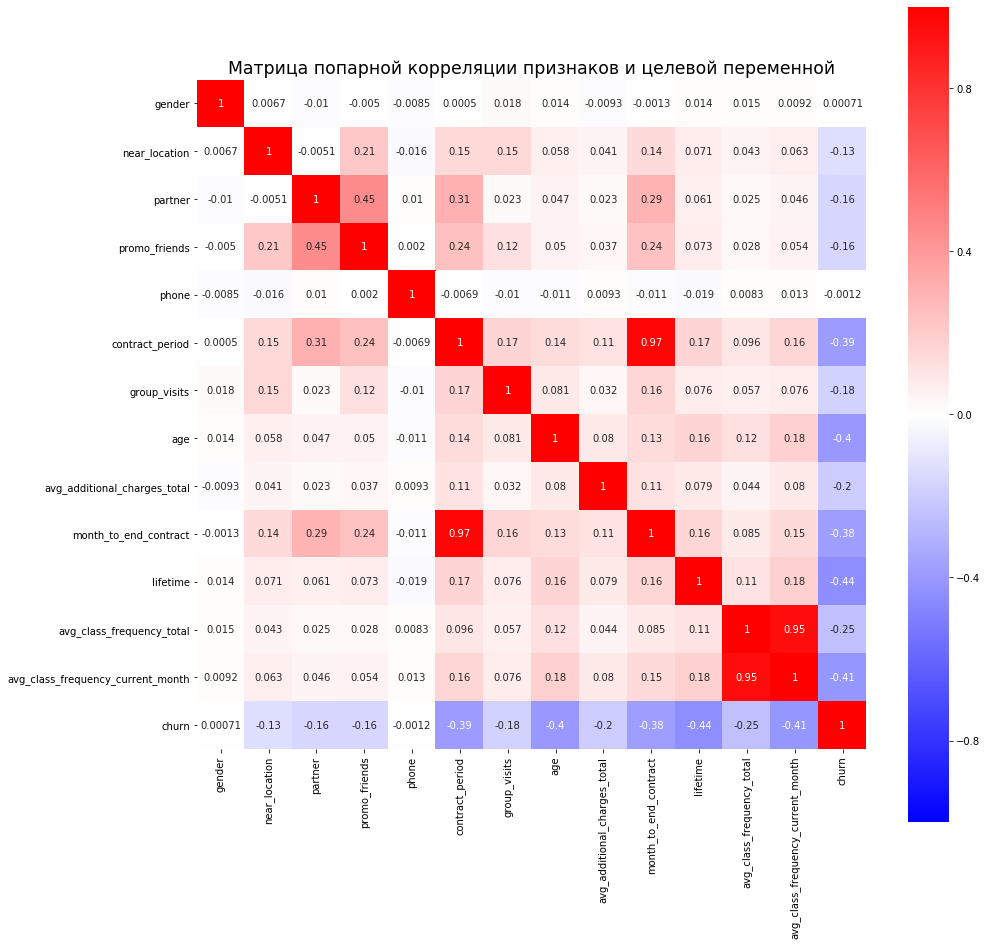

In [11]:
plt.rcParams['figure.figsize']=(15, 15)
cm = gym_churn.corr()
sns.heatmap(cm, annot = True, square=True, cmap='bwr', vmin=-1, vmax=1)
plt.title('Матрица попарной корреляции признаков и целевой переменной', size='xx-large')
plt.show()

Судя по матрице корреляции есть сильная зависимость между длительностью контракта и временем до его окончания и между средним количеством посещений в предыдущий месяц и средним количеством посещений за все время действия абонементов.

## Вывод
1. На вероятность оттока клиента заметно влиют время с момента первого обращения в фитнес-центр, количество месяцев до конца действия абонемента и его длительность, близость локации и возраст.
2. Есть сильная зависимость между длительностью контракта и временем до его окончания и между средним количеством посещений в предыдущий месяц и средним количеством посещений за все время действия абонементов.

## Часть 3. Модель прогнозирования оттока клиентов. <a id='3'></a>

В таблицу `X` запишем информацию о признаках каждого клиента, а в `y` факт оттока в текущем месяце.

In [12]:
X = gym_churn.drop(columns='churn', axis=0)
y = gym_churn['churn']
display(X.head())
display(y.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078


0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

Разделим выборку на обучающую и валидационную.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test) 
print(X_train_st)

[[-1.01511421  0.4175068   1.03175391 ...  1.12734972  1.75580418
   1.61822807]
 [-1.01511421  0.4175068  -0.96922337 ...  5.88138322 -0.2239674
  -0.01340886]
 [ 0.98511083  0.4175068   1.03175391 ...  0.3350108  -0.84308456
  -0.80541199]
 ...
 [-1.01511421  0.4175068  -0.96922337 ... -0.19321515 -0.77348266
  -0.57668773]
 [ 0.98511083  0.4175068  -0.96922337 ... -0.45732812  0.04081312
  -0.02578747]
 [ 0.98511083  0.4175068  -0.96922337 ...  0.86323674  0.45401693
   0.59844875]]


Обучим 2 модели: логистическую регрессию и случайный лес. Для каждой модели посчитаем accuracy, precision и recall.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model1 = LogisticRegression(solver='liblinear')
model1.fit(X_train_st, y_train)

model2 = RandomForestClassifier(n_estimators = 100, random_state = 0)
model2.fit(X_train_st, y_train)

for i in [['Модель логистической регрессии', model1], ['Модель случайного леса', model2]]:
    predictions = i[1].predict(X_test_st)
    print(i[0])
    print()
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format((recall_score(y_test, predictions))))
    print()
    print()

Модель логистической регрессии

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


Модель случайного леса

Accuracy: 0.92
Precision: 0.84
Recall: 0.81




Модель, основанная на логистической регрессии показывает себя лучше. Посмотрим на какие признаки она больше всего ориентировалась.

In [16]:
features_importance = pd.DataFrame({'features' : X.columns, 'coeffs' : model1.coef_[0]})
features_importance['abs_coeffs'] = features_importance['coeffs'].abs()
display(features_importance.sort_values(by='abs_coeffs', ascending=False))

,features,coeffs,abs_coeffs
12,avg_class_frequency_current_month,-4.426492,4.426492
10,lifetime,-3.720057,3.720057
11,avg_class_frequency_total,3.290506,3.290506
7,age,-1.074359,1.074359
5,contract_period,-0.703741,0.703741
8,avg_additional_charges_total,-0.541020,0.541020
9,month_to_end_contract,-0.520089,0.520089
6,group_visits,-0.385778,0.385778
3,promo_friends,-0.268180,0.268180
2,partner,-0.082845,0.082845


1. Больше всего модель опирается на среднюю посещаемость за предыдущий месяц и на среднюю посещаемость за все время и на то, сколько времени прошло с первого посещения.
2. Меньше всего модель опирается на наличие контактного телефона и пол.

## Вывод
При предсказании оттока клиентов больше всего стоит опираться на среднюю посещаемость за предыдущий месяц (чем чаще посещает - тем хуже), на среднюю посещаемость за все время (чем чаще посещает - тем лучше) и на то, сколько времени прошло с первого посещения (чем больше - тем хуже).

## Часть 4. Кластеризация клиентов. <a id='4'></a>

Стандартизируем данные.

In [17]:
st_sc = StandardScaler()
st_sc.fit(X)
X_for_clusters = st_sc.transform(X) 
print(X_for_clusters)

[[ 0.97970588  0.42788074  1.02686062 ... -0.19332863 -1.91191971
  -1.67847198]
 [-1.0207145   0.42788074 -0.973842   ...  0.87368001  0.04517569
   0.1360137 ]
 [-1.0207145   0.42788074  1.02686062 ... -0.46008079 -0.02049263
  -0.02901851]
 ...
 [ 0.97970588  0.42788074  1.02686062 ... -0.46008079  0.93313947
   1.01103141]
 [-1.0207145   0.42788074  1.02686062 ... -0.19332863 -0.25604937
  -0.16225246]
 [ 0.97970588 -2.33709981  1.02686062 ... -0.72683295 -0.79947418
  -0.69509885]]


Построим матрицу расстояний и нарисуем дендограмму по ней.

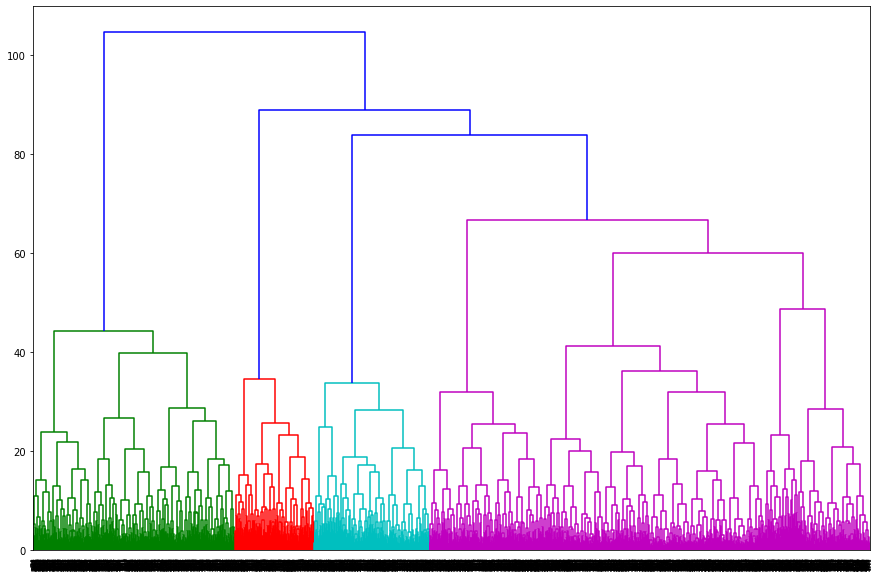

In [18]:
linked = linkage(X_for_clusters, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Можно разбить всех клиентов на 5 кластеров. Сделаем это моделью K-Means.

In [19]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_for_clusters)
gym_churn['cluster'] = labels
gym_churn.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


1. Первая группа выделяется отсутствием контактного телефона.
1. Во второй группе почти нет участников акций.
1. Пятая группа выделяется большой длительностью абонементов.

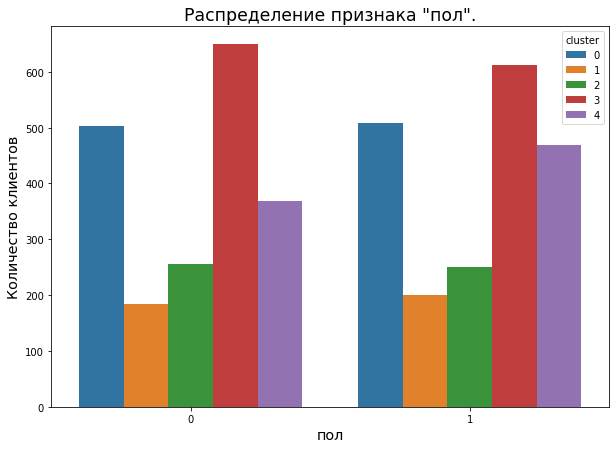

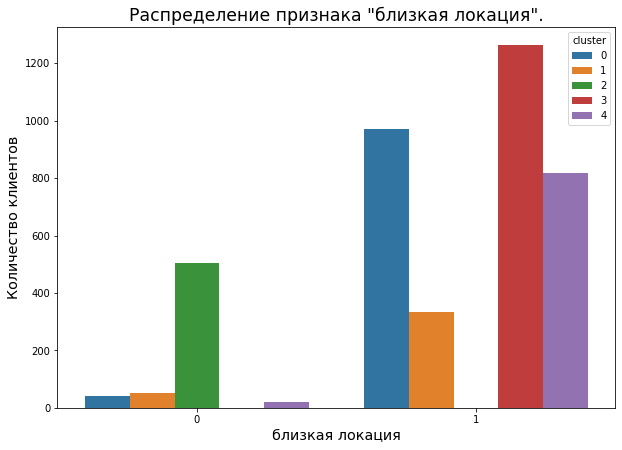

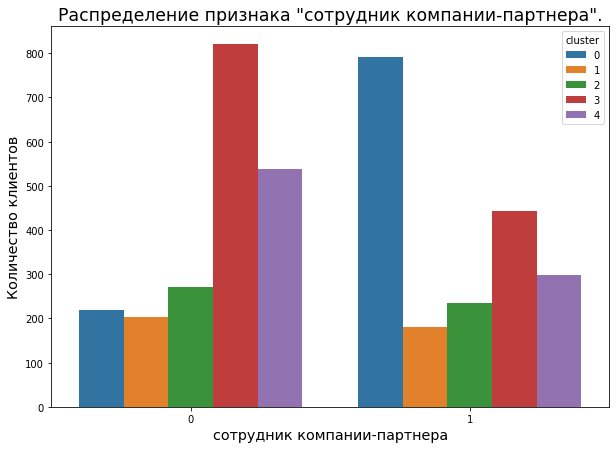

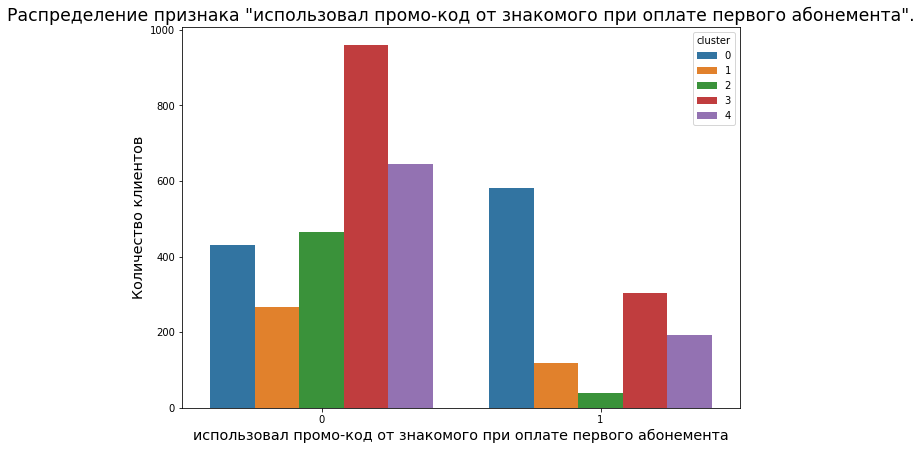

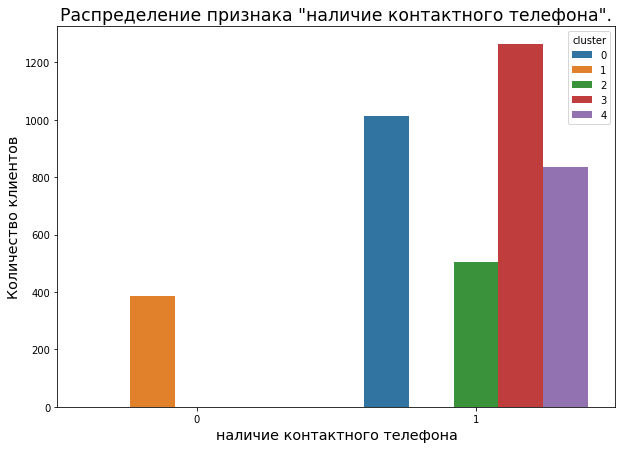

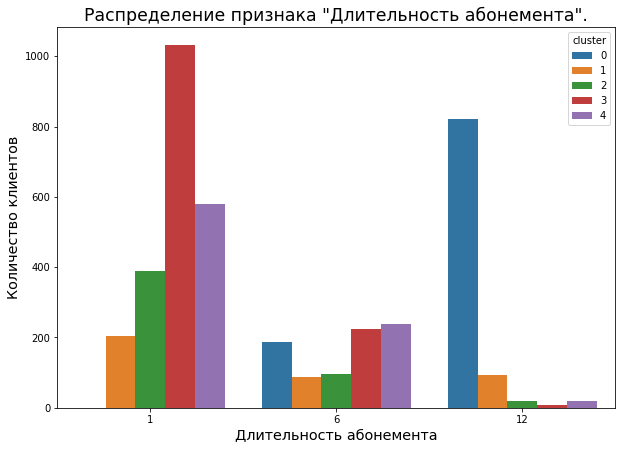

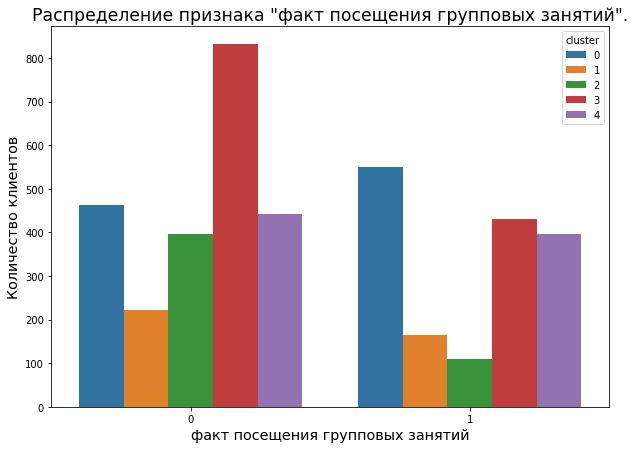

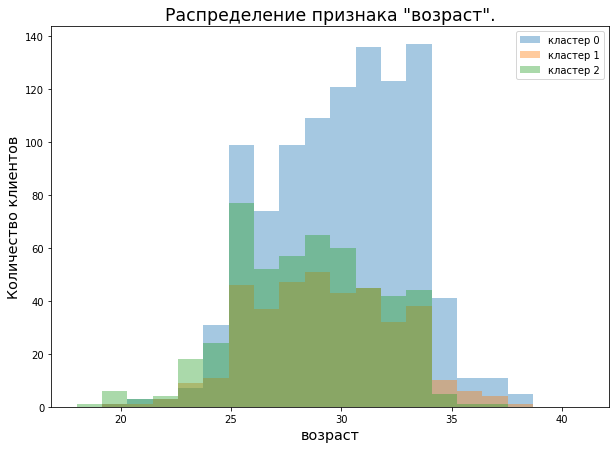

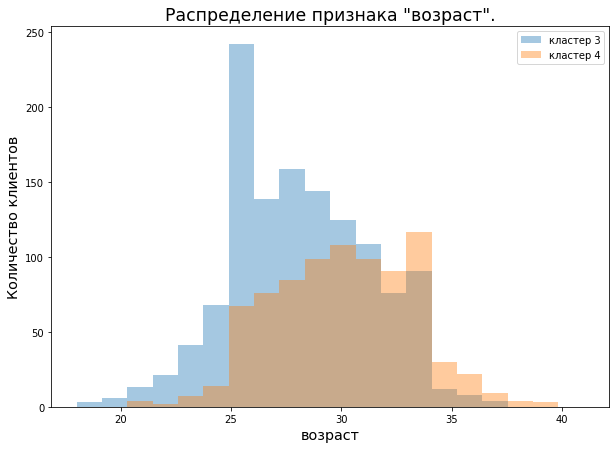

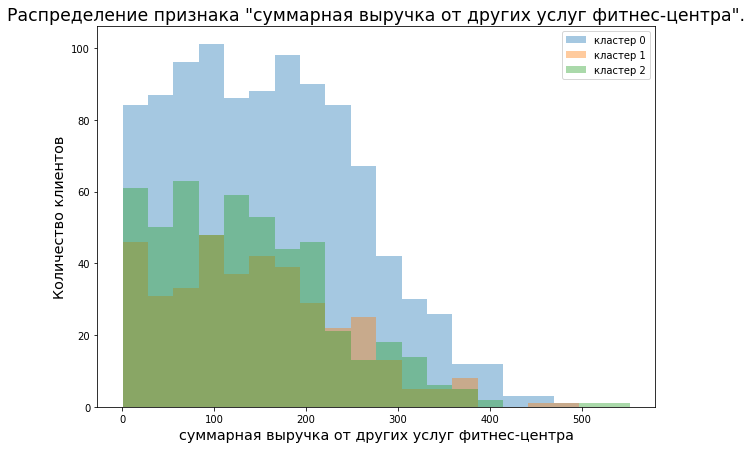

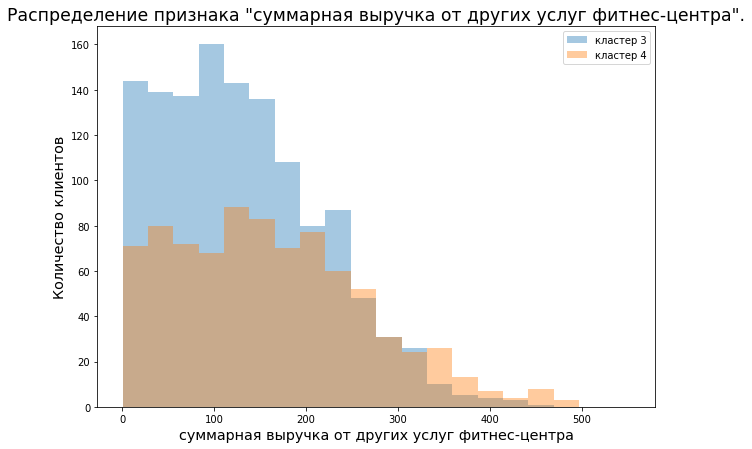

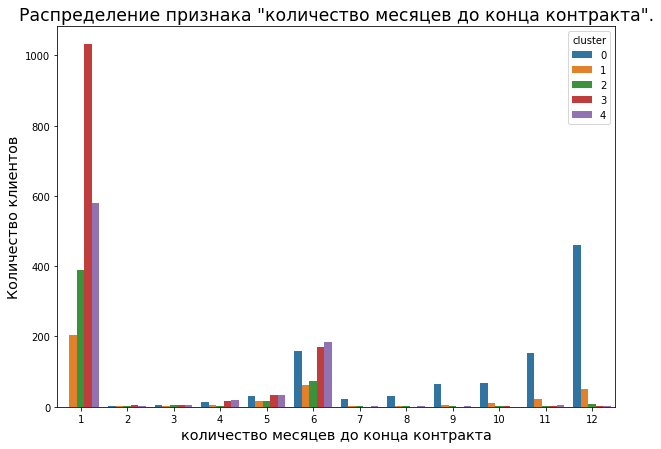

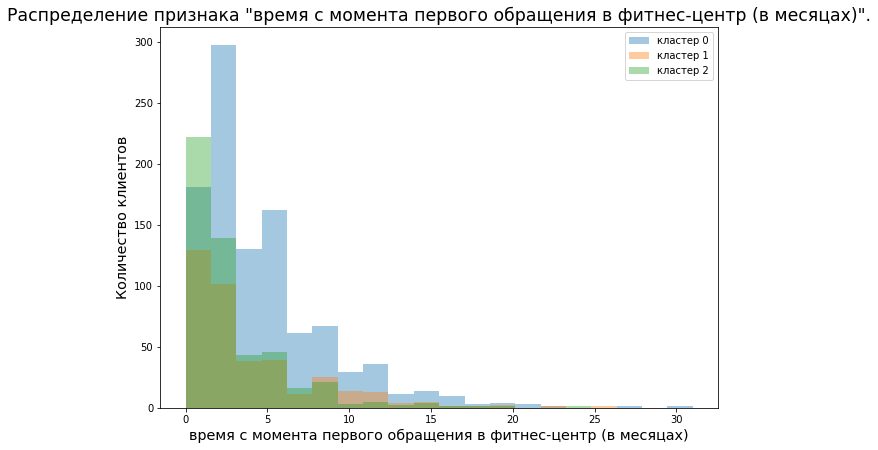

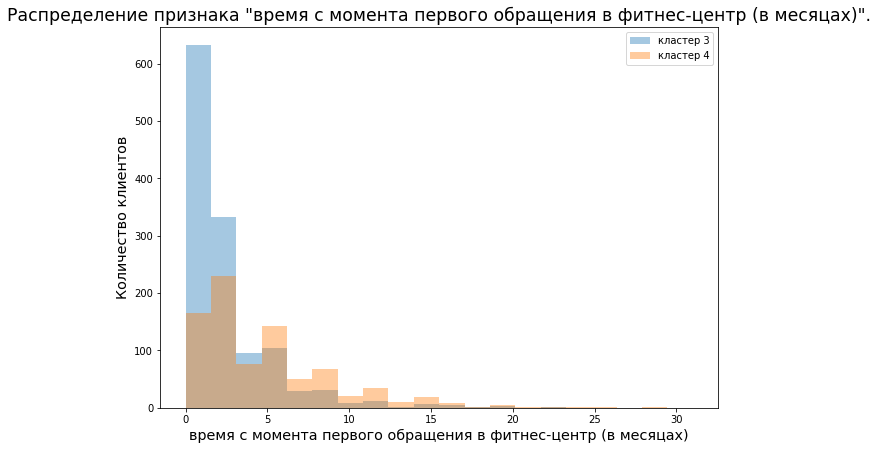

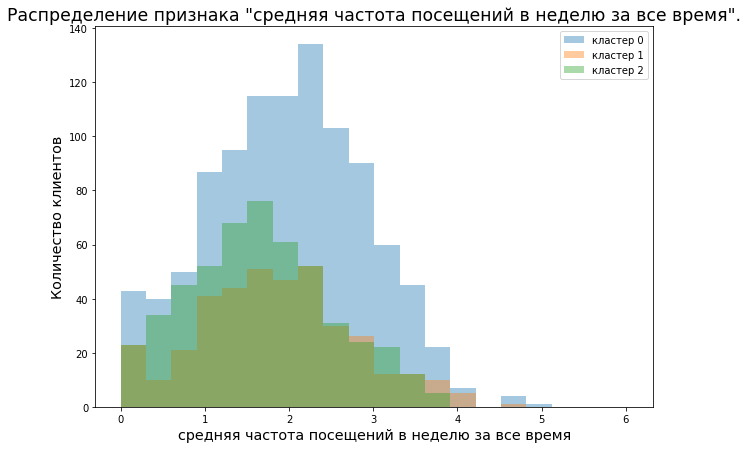

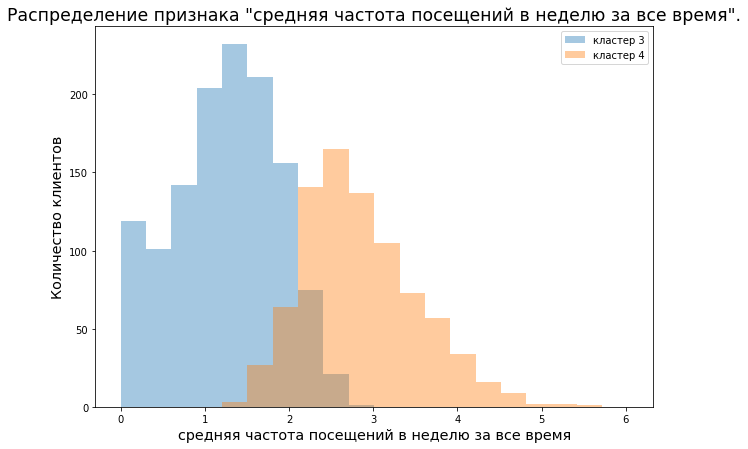

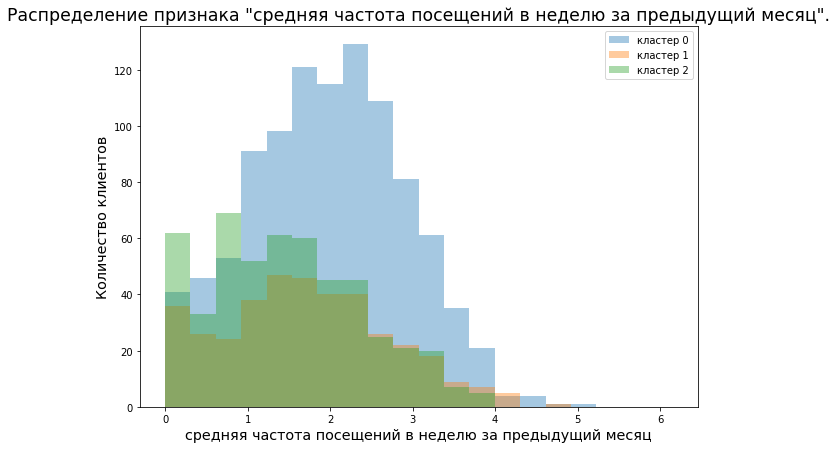

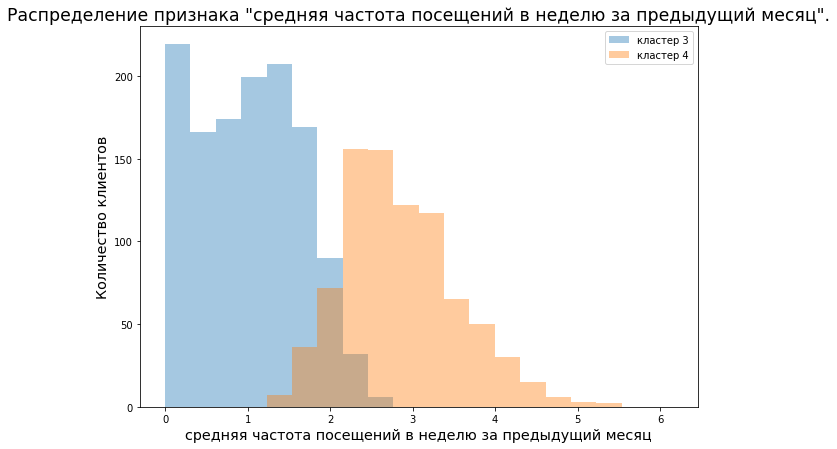

In [20]:
plt.rcParams['figure.figsize']=(10, 7)
for column in features:
    if column in ['age', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total', 'lifetime']:
        x_min = gym_churn[column].min()
        x_max = gym_churn[column].max()
        step = (x_max - x_min) / 20
        x = x_min
        bins = []
        for i in range(0, 21):
            bins.append(x)
            x += step
        for i in range(0, 5):
            do_hist(x=gym_churn[gym_churn['cluster']==i][column], title='Распределение признака "'+translator[column]+'".', label='кластер {}'.format(i), 
                    bins=bins, xlabel=translator[column], ylabel='Количество клиентов')
            if i in [2, 4]:
                plt.legend()
                plt.show()
    else:
        do_countplot(y=gym_churn[column], title='Распределение признака "'+translator[column]+'".', xlabel=translator[column], ylabel='Количество клиентов', hue=gym_churn['cluster'])
        plt.show()

1. Первая группа выделяется отсутствием контактного телефона.
1. Во второй группе почти нет участников акций, они относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
1. В третьей группе относительно возрастные клиенты, часто посещающие центр.
1. В четвертой группе сотрудники компаний-партнеров, относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
1. Пятая группа выделяется большой длительностью абонементов, относительно возрастные, довольно часто сотрудники компании-партнера.

Для каждого кластера посчитаем долю оттока.

In [21]:
display(gym_churn.groupby('cluster')['churn'].mean().sort_values(ascending=False))

cluster
3    0.514263
2    0.443564
1    0.267532
4    0.068100
0    0.027695
Name: churn, dtype: float64

Меньше всего отток у второй группы. Приемлимый отток у 4 и 1 групп. У третьей и пятой групп отток очень высокий.

## Вывод:
1. Клиентов можно разделить на 5 групп:
    1. Первая группа выделяется отсутствием контактного телефона.
    1. Во второй группе почти нет участников акций, они относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
    1. В третьей группе относительно возрастные клиенты, часто посещающие центр.
    1. В четвертой группе сотрудники компаний-партнеров, относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
    1. Пятая группа выделяется большой длительностью абонементов, относительно возрастные, довольно часто сотрудники компании-партнера.
2. Меньше всего отток у второй группы. Приемлимый отток у 4 и 1 групп. У третьей и пятой групп отток очень высокий.

## Часть 5. Вывод. <a id='5'></a>

1. Проделанная работа:
    1. Мы изучили общую информацию о данных.
    6. Мы изучили средние значения признаков, их попарную корреляцию и корреляцию признаков и целевой переменной.
    3. Мы построили модель, предсказывающую уйдет ли клиент в следующем месяце.
    4. Мы машинным обучением распределили клиентов на 5 кластеров


2. В ходе исследования я пришел к следующим выводам:
    1. На вероятность оттока клиента заметно влиют время с момента первого обращения в фитнес-центр, количество месяцев до конца действия абонемента и его длительность, близость локации и возраст.
    2. Есть сильная зависимость между длительностью контракта и временем до его окончания и между средним количеством посещений в предыдущий месяц и средним количеством посещений за все время действия абонементов. 
    2. При предсказании оттока клиентов больше всего стоит опираться на среднюю посещаемость за предыдущий месяц (чем чаще посещает - тем хуже), на среднюю посещаемость за все время (чем чаще посещает - тем лучше) и на то, сколько времени прошло с первого посещения (чем больше - тем хуже).
    1. Клиентов можно разделить на 5 групп:
        1. Первая группа выделяется отсутствием контактного телефона.
        1. Во второй группе почти нет участников акций, они относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
        1. В третьей группе относительно возрастные клиенты, часто посещающие центр.
        1. В четвертой группе сотрудники компаний-партнеров, относительно молодые, только недавно начали пользоваться услугами центра и делают это достаточно редко.
        1. Пятая группа выделяется большой длительностью абонементов, относительно возрастные, довольно часто сотрудники компании-партнера.
    2. Меньше всего отток у второй группы. Приемлимый отток у 4 и 1 групп. У третьей и пятой групп отток очень высокий.

Исходя из этого исследования, я бы дал следующие рекомендации:
1. К нам почти не ходят клиенты старше 33. Возможно стоит сделать для них скидку.
2. К нам перестают ходить люди, которые за последний месяц посещали центр часто. Возможно они добились своей цели и ушли. Можно сделать 2 типа абонементов: дешевый: с ограничением на количество тренировок (12 в месяц) и дорогой: без ограничения.
3. К нам перестают ходить клиенты, которые давно пользуются нашими услугами. Возможно стоит сделать скидку для постоянных клиентов.